In [1]:
#Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
#Loading the dataset
customers = pd.read_csv(r'C:\Users\Shraddha\Downloads\Zeotap Assignment\Customers.csv')
transactions = pd.read_csv(r'C:\Users\Shraddha\Downloads\Zeotap Assignment\Transactions.csv')

In [3]:
# Merging customer and transaction data
customer_data = transactions.groupby('CustomerID').agg(
    TotalValueSum=('TotalValue', 'sum'),
    TotalValueMean=('TotalValue', 'mean'),
    TransactionCount=('TransactionID', 'count')
).reset_index()

customer_data = pd.merge(customer_data, customers, on='CustomerID')

In [4]:
#Converting SignupDate to a datetime and calculating signup duration
customer_data['SignupDate'] = pd.to_datetime(customer_data['SignupDate'])
customer_data['SignupDuration'] = (pd.Timestamp.now() - customer_data['SignupDate']).dt.days

In [5]:
#Features for clustering
features = customer_data[['TotalValueSum', 'TotalValueMean', 'TransactionCount', 'SignupDuration']]
if 'Region' in customer_data.columns:
    features = pd.get_dummies(features.join(customer_data['Region']), columns=['Region'])

In [6]:
#Scaling features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [7]:
#Clustering with K-Means
k = 4  # Number of clusters (choose based on experimentation or elbow method)
kmeans = KMeans(n_clusters=k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(scaled_features)

C:\Users\Shraddha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Shraddha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [8]:
# Evaluating clustering with DB Index
db_index = davies_bouldin_score(scaled_features, customer_data['Cluster'])
print(f'Davies-Bouldin Index for {k} clusters: {db_index:.2f}')

Davies-Bouldin Index for 4 clusters: 1.12


In [9]:
#Dimensionality Reduction with PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

In [10]:
#Creating a dataframe with PCA results and cluster labels
visualization_data = pd.DataFrame(pca_features, columns=['PCA1', 'PCA2'])
visualization_data['Cluster'] = customer_data['Cluster']

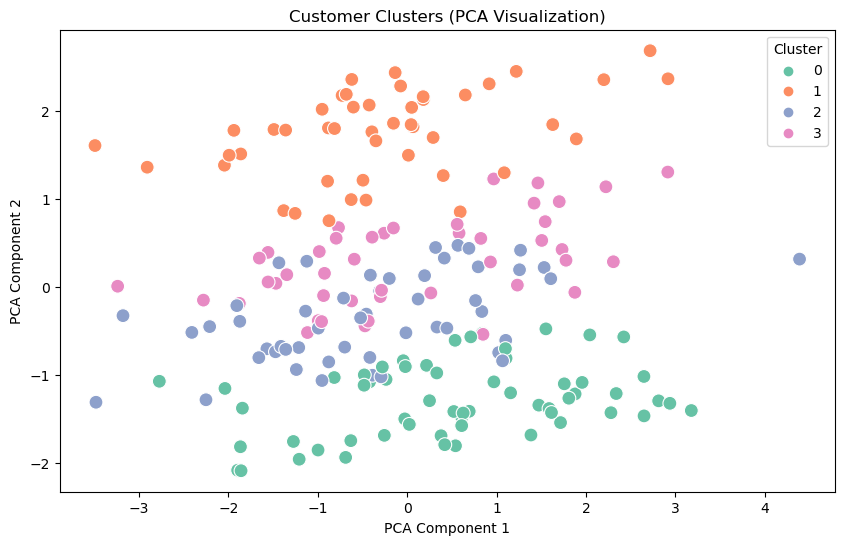

In [11]:
#Scatter Plot of Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visualization_data, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100)
plt.title('Customer Clusters (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

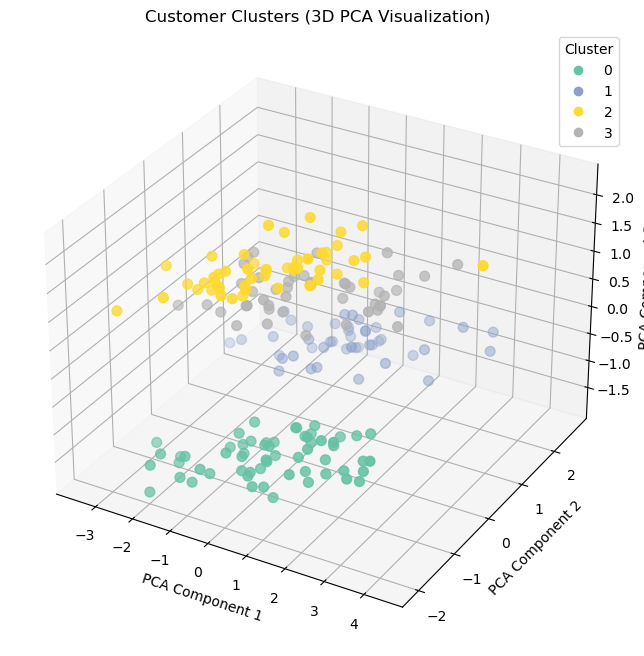

In [12]:
#3D Visualization
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
pca_features_3d = pca_3d.fit_transform(scaled_features)
visualization_data_3d = pd.DataFrame(pca_features_3d, columns=['PCA1', 'PCA2', 'PCA3'])
visualization_data_3d['Cluster'] = customer_data['Cluster']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    visualization_data_3d['PCA1'], 
    visualization_data_3d['PCA2'], 
    visualization_data_3d['PCA3'], 
    c=visualization_data_3d['Cluster'], cmap='Set2', s=50
)
ax.set_title('Customer Clusters (3D PCA Visualization)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.show()

In [13]:
#Ensuring all relevant columns are numeric
numeric_data = customer_data.select_dtypes(include='number')

In [14]:
#Including the 'Cluster' column if it's excluded
numeric_data['Cluster'] = customer_data['Cluster']

In [15]:
#Grouping by 'Cluster' and calculating mean
cluster_means = numeric_data.groupby('Cluster').mean()

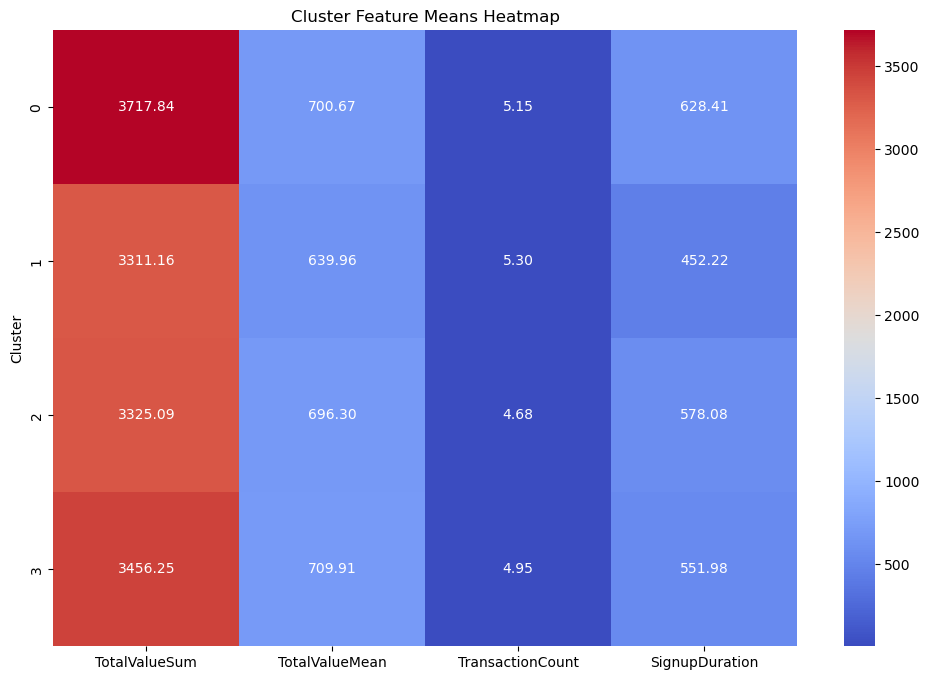

In [16]:
#Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Cluster Feature Means Heatmap")
plt.show()

In [18]:
# Save Clustered Data
customer_data.to_csv('Shraddha_Harihar_Clustering.csv', index=False)